In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa 
from tqdm.notebook import tqdm
import multiprocessing

#tf.config.set_visible_devices([], 'GPU')
np.set_printoptions(suppress=True)

In [2]:
class LabelEncoder:
    
    def __init__(self):
        self.num_points = 2048
    
    def encode(self, chromatogram, locs, scales):
        labels = np.zeros((len(chromatogram)))
        for loc, scale in zip(locs, scales):
            left = np.clip(int((loc-3*scale) * self.num_points), 0, self.num_points)
            right = np.clip(int((loc+3*scale) * self.num_points), 0, self.num_points)
            
            labels[left : right] = 1

        
        return labels
            
    def decode(self, predictions, threshold=0.5):
        index = np.where(predictions[:, 0] > threshold)[0]
        
        t = self.bins[index]
        t += predictions[:, 1][index] * self.grid_size
        return t, predictions[:, 2][index] * self.grid_size, predictions[:, 0][index]

encoder = LabelEncoder()


In [3]:
def gaussian(x, amplitude, loc, scale):
    return amplitude * np.exp((-(x - loc)**2) / (2 * scale**2))

def generate_example(_):
    t = np.linspace(0, 1, 2048)
    size = np.random.randint(1, 10)
    locs = np.random.uniform(0.05, 0.95, size=size)
    scales = np.random.uniform(0.01, 0.02, size=size)
    amplitudes = np.random.uniform(10, 250, size=size)

    g = np.zeros_like(t)

    for loc, scale, amplitude in zip(locs, scales, amplitudes):
        g += gaussian(t, amplitude, loc, scale)

    g += np.random.randn(g.shape[0]) * np.random.uniform(1, 4)
    g /= g.max()
    
    y = encoder.encode(g, locs, scales)
    
    #y = np.stack([y, np.where(y == 0, 1, 0)], axis=-1)
    
    return g, y

with multiprocessing.Pool() as pool:
    data = [i for i in tqdm(pool.imap(generate_example, range(10_000)), total=10_000)]
    

y = np.stack([d[1] for d in data])[..., None]
X = np.stack([d[0] for d in data])[..., None]
t = np.linspace(0, 1, 2048)


In [70]:
from tensorflow.keras import layers


def conv_block(x, filters, kernel_size, stride, batch_norm=True):
    x = layers.Conv1D(filters, kernel_size, stride, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def encoder_block(x, filters, kernel_size, stride, pool_size=2):
    x = conv_block(x, filters, kernel_size, stride)
    x = conv_block(x, filters, kernel_size, stride)
    x_skip = x
    x = layers.MaxPool1D(pool_size)(x)
    return x, x_skip

def decoder_block(x, x_skip, filters, kernel_size, stride, final_layer):
    x = layers.Concatenate()([x_skip, x])
    
    x = conv_block(x, filters, kernel_size, 1)
    x = conv_block(x, filters, kernel_size, 1)
    if not final_layer:
        x = layers.Conv1DTranspose(filters, kernel_size=kernel_size, strides=2, padding='same')(x)
    else:
        x = layers.Conv1D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    
    return x

def bottleneck_block(x, filters, kernel_size, stride):
    x = conv_block(x, filters, kernel_size, stride)
    x = conv_block(x, filters, kernel_size, stride)
    x = layers.Conv1DTranspose(filters, kernel_size=kernel_size, strides=2, padding='same')(x)
    return x

#height
# 8192 -> 4096 -> 2048 -> 1024 -> 512 -> 256 -> 128 -> 64
#depth:
# 1    -> 64   -> 64   -> 128  -> 128 -> 256 -> 256 -> 512


#height:
# 64 -> 128 -> 256 -> ... -> 8192
#depth:
# 512 -> 256 -> 128 -> ... -> 2


def UNet():
    
    inputs = layers.Input((2048, 1), dtype='float32')
    x = inputs
    
    x1, x1_skip = encoder_block(x, 64, 7, 1)
    # (1024, 64)
    x2, x2_skip = encoder_block(x1, 64, 7, 1)
    # (512, 128)
    x3, x3_skip = encoder_block(x2,  128, 7, 1)
    # (256, 256)
    x4, x4_skip = encoder_block(x3, 128, 7, 1)
    # (128,  512)
    x5, x5_skip = encoder_block(x4, 256, 7, 1)
    # (64,  1024)
    x = bottleneck_block(x5, 256, 7, 1)
    # (128,  1024)
    x = decoder_block(x, x5_skip, 128, 7, 2, False)
    # (256, 512)
    x = decoder_block(x, x4_skip, 128, 7, 2, False)
    # (512, 256)
    x = decoder_block(x, x3_skip, 64, 7, 2, False)
    # (1024, 128)
    x = decoder_block(x, x2_skip, 64, 7, 2, False)
    # (2048, 64)
    x = decoder_block(x, x1_skip, 1, 7, 1, True)

    return tf.keras.Model(inputs=inputs, outputs=x)
# Loss should be categorical crossentropy (with from_logits=True) (no need to customize)
        

In [71]:
#model = UNet()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4))
model.fit(X[:9000], y[:9000], epochs=6, verbose=1)

Epoch 1/6
282/282 [==============================] - 22s 68ms/step - loss: 0.0742
Epoch 2/6
282/282 [==============================] - 19s 68ms/step - loss: 0.0404
Epoch 3/6
282/282 [==============================] - 19s 68ms/step - loss: 0.0344
Epoch 4/6
282/282 [==============================] - 19s 69ms/step - loss: 0.0294
Epoch 5/6
282/282 [==============================] - 19s 68ms/step - loss: 0.0266
Epoch 6/6
282/282 [==============================] - 19s 69ms/step - loss: 0.0225


In [1]:
ID = 9211
prediction = model.predict(X[ID][None])[0]
pos = np.where(tf.nn.sigmoid(prediction) > 0.5)[0]
plt.plot(X[ID])
plt.scatter(pos, [-.1] * len(pos), color='C1', s=5)

NameError: name 'model' is not defined

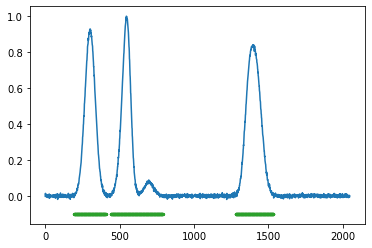

In [75]:
ID = 9211
prediction = model.predict(X[ID][None])[0]
pos = np.where(y[ID] > 0.5)[0]
plt.plot(X[ID])
plt.scatter(pos, [-.1] * len(pos), color='C2', s=5)

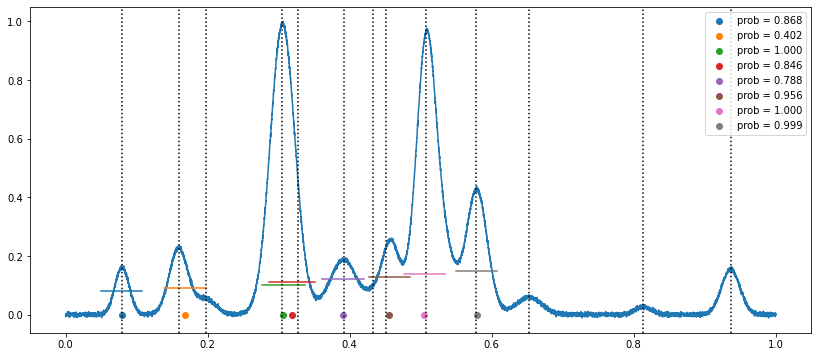

In [15]:
plt.figure(figsize=(14, 6))

ID = 28005

prediction = model.predict(X[ID][None,:,None])[0]
#print(prediction)
loc, width, prob = encoder.decode(prediction, 0.4)

plt.plot(t, X[ID])

for i, (l, w, p) in enumerate(zip(loc, width, prob)):
    plt.scatter(l, 0, label=f'prob = {p:.3f}', c=f'C{i}')
    plt.plot([l-w/2, l+w/2], [.080+(i*.010), .080+(i*.010)], color=f'C{i}')


gt = encoder.decode(y[ID])
for l in gt[0]:
    plt.axvline(l, color='black', linestyle=':')
    
plt.legend()
#for _ in np.linspace(0, 1, 33):
#    plt.axvline(_, color='black', alpha=0.5)

<tf.Tensor: shape=(16, 3), dtype=float32, numpy=
array([[0.0128063 , 0.48784685, 0.87706196],
       [0.02687609, 0.5462892 , 0.8811845 ],
       [0.00516534, 0.5774112 , 0.8927452 ],
       [0.00355822, 0.50242037, 0.90840554],
       [0.02287519, 0.51355606, 0.89368606],
       [0.02860397, 0.53064525, 0.8784089 ],
       [0.01375076, 0.5565049 , 0.8740363 ],
       [0.009518  , 0.5333078 , 0.885679  ],
       [0.01485148, 0.48970374, 0.86763096],
       [0.01686445, 0.5774664 , 0.88528454],
       [0.02284753, 0.4384066 , 0.85328984],
       [0.00320539, 0.7893832 , 0.89673626],
       [0.92290163, 0.18646905, 0.9088602 ],
       [0.0062753 , 0.57433695, 0.8725667 ],
       [0.01003009, 0.484492  , 0.874908  ],
       [0.01315486, 0.5190783 , 0.8897631 ]], dtype=float32)>

In [701]:
y[ID]

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [1.        , 0.192     , 1.49927321],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [542]:
np.linspace(0, 1, 17)

array([0.    , 0.0625, 0.125 , 0.1875, 0.25  , 0.3125, 0.375 , 0.4375,
       0.5   , 0.5625, 0.625 , 0.6875, 0.75  , 0.8125, 0.875 , 0.9375,
       1.    ])